In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv(r'/content/drive/My Drive/AirPassengers.csv')

Using TensorFlow backend.


In [3]:
#!pip install tslib

In [4]:
 import tslib
 #!ts
 t = pd.Timestamp.now()
print (t)
#print (t.type())
#t.date_time.map(lambda x: x.strftime('%Y-%m-%d'))

2020-06-18 14:28:22.199659


In [3]:
print (df)
df.head()
df.TIMESTAMP = pd.to_datetime(df.TIMESTAMP, dayfirst=True)
#df['month'] = pd.DatetimeIndex(df['TIMESTAMP']).month
#df 
#del df['month']
df = df.set_index("TIMESTAMP")

    TIMESTAMP  AirPassengers
0     1949-01            112
1     1949-02            118
2     1949-03            132
3     1949-04            129
4     1949-05            121
..        ...            ...
139   1960-08            606
140   1960-09            508
141   1960-10            461
142   1960-11            390
143   1960-12            432

[144 rows x 2 columns]


## We use df[:-12] since we want a 12 month forecast, you can choose it according to your need.

In [4]:
train, test = df[:-12], df[-12:]
print (train)

            AirPassengers
TIMESTAMP                
1949-01-01            112
1949-02-01            118
1949-03-01            132
1949-04-01            129
1949-05-01            121
...                   ...
1959-08-01            559
1959-09-01            463
1959-10-01            407
1959-11-01            362
1959-12-01            405

[132 rows x 1 columns]


##Always scale the data

In [5]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

N_input -> number of months (12 in our case as above)

n_features -> target variable

In [6]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

#LSTM

In [7]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [8]:
model.fit_generator(generator,epochs=50)

Epoch 1/50
20/20 [==============================] - 1s 45ms/step - loss: 0.0871
Epoch 2/50
20/20 [==============================] - 0s 17ms/step - loss: 0.0233
Epoch 3/50
20/20 [==============================] - 0s 19ms/step - loss: 0.0145
Epoch 4/50
20/20 [==============================] - 0s 19ms/step - loss: 0.0125
Epoch 5/50
20/20 [==============================] - 0s 20ms/step - loss: 0.0111
Epoch 6/50
20/20 [==============================] - 0s 18ms/step - loss: 0.0131
Epoch 7/50
20/20 [==============================] - 0s 18ms/step - loss: 0.0131
Epoch 8/50
20/20 [==============================] - 0s 19ms/step - loss: 0.0098
Epoch 9/50
20/20 [==============================] - 0s 17ms/step - loss: 0.0096
Epoch 10/50
20/20 [==============================] - 0s 17ms/step - loss: 0.0086
Epoch 11/50
20/20 [==============================] - 0s 18ms/step - loss: 0.0086
Epoch 12/50
20/20 [==============================] - 0s 17ms/step - loss: 0.0100
Epoch 13/50
20/20 [==================

In [11]:
pred_list = []
# print(train[-n_input:]) # 12 scaled numbers will be printed 
batch = train[-n_input:].reshape((1, n_input, n_features))   
#print(batch) # same output reshaped

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

print(batch) # after prediction of the 12 months

[[[0.59329385]
  [0.62398636]
  [0.67730951]
  [0.69944966]
  [0.81802708]
  [0.96282744]
  [1.08895719]
  [1.01493871]
  [0.82329202]
  [0.69742519]
  [0.67317516]
  [0.67809176]]]


In [13]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, columns=['Prediction'])

df_test = pd.concat([df,df_predict], axis=1)
print(df_test) # only for 12

            AirPassengers  Prediction
TIMESTAMP                            
1949-01-01            112         NaN
1949-02-01            118         NaN
1949-03-01            132         NaN
1949-04-01            129         NaN
1949-05-01            121         NaN
...                   ...         ...
1960-08-01            606  565.797114
1960-09-01            508  478.597868
1960-10-01            461  421.328460
1960-11-01            390  410.294696
1960-12-01            432  412.531753

[144 rows x 2 columns]


No handles with labels found to put in legend.


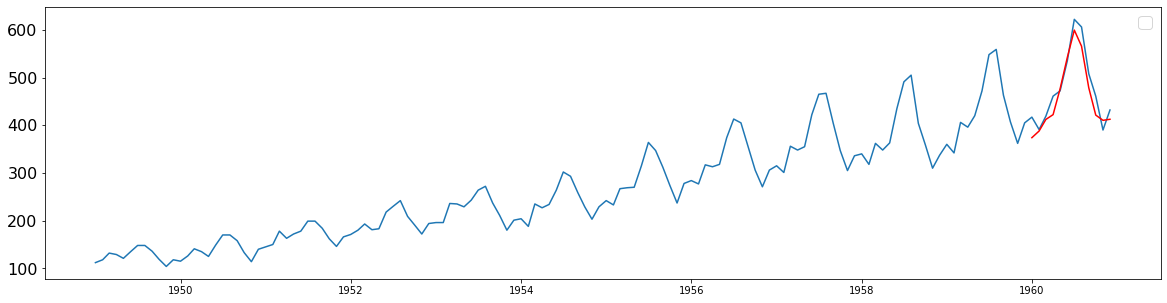

In [14]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['AirPassengers'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=10)
plt.yticks(fontsize=16)
plt.show()

# THIS time predict next 12 months 

In [15]:
train = df

In [17]:
scaler.fit(train)
train = scaler.transform(train)
train.shape

(144, 1)

In [18]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [19]:
model.fit_generator(generator,epochs=90)

Epoch 1/90
22/22 [==============================] - 0s 20ms/step - loss: 0.0024
Epoch 2/90
22/22 [==============================] - 0s 20ms/step - loss: 0.0030
Epoch 3/90
22/22 [==============================] - 0s 18ms/step - loss: 0.0021
Epoch 4/90
22/22 [==============================] - 0s 18ms/step - loss: 0.0021
Epoch 5/90
22/22 [==============================] - 0s 17ms/step - loss: 0.0024
Epoch 6/90
22/22 [==============================] - 0s 17ms/step - loss: 0.0019
Epoch 7/90
22/22 [==============================] - 0s 18ms/step - loss: 0.0024
Epoch 8/90
22/22 [==============================] - 0s 17ms/step - loss: 0.0021
Epoch 9/90
22/22 [==============================] - 0s 19ms/step - loss: 0.0027
Epoch 10/90
22/22 [==============================] - 0s 18ms/step - loss: 0.0026
Epoch 11/90
22/22 [==============================] - 0s 19ms/step - loss: 0.0030
Epoch 12/90
22/22 [==============================] - 0s 18ms/step - loss: 0.0030
Epoch 13/90
22/22 [==================

In [20]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

# Create extra dates for which the prediction is to be done

In [22]:
from pandas.tseries.offsets import DateOffset
#df['month'] = pd.DatetimeIndex(df['TIMESTAMP']).month
add_dates = [ df.index[-1]+ DateOffset(months=x) for x in range(0,13) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)
future_dates.head()

,AirPassengers
1961-01-01,NaN
1961-02-01,NaN
1961-03-01,NaN
1961-04-01,NaN
1961-05-01,NaN


In [23]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])
df_predict.head()
df_proj = pd.concat([df,df_predict], axis=1)
df_proj.head()

,AirPassengers,Prediction
1949-01-01,112.0,NaN
1949-02-01,118.0,NaN
1949-03-01,132.0,NaN
1949-04-01,129.0,NaN
1949-05-01,121.0,NaN


No handles with labels found to put in legend.


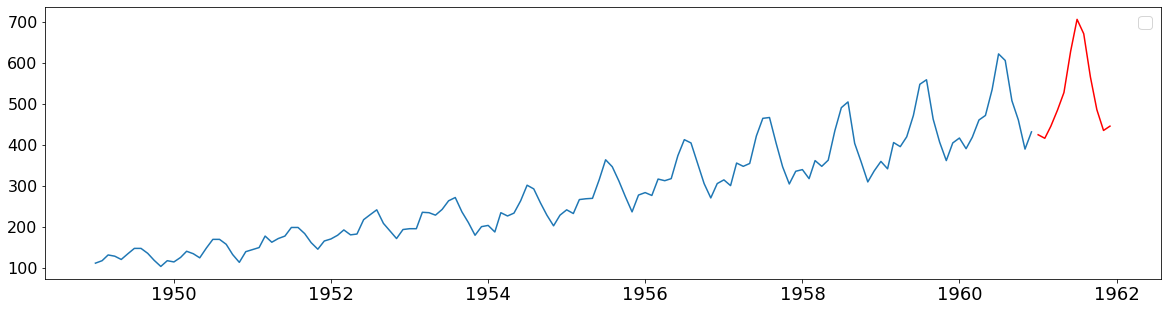

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(df_proj.index, df_proj['AirPassengers'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()